In [42]:
##################################
#  独自ライブラリー： mshow
# (複数に対応したノートブック上画像表示)
##################################
import cv2;import numpy as np;import matplotlib as mpl;import matplotlib.pyplot as plt
%matplotlib inline
def mshow(img1=None, img2=None, img3=None, img4=None, img5=None, *, img_list = []):

    imgs = list(filter( lambda x: x is not None, [img1, img2, img3, img4, img5])) 
    imgs.extend(img_list)
    
    if len(imgs) == 1:
        # 一枚のとき
        imgs[0] = imgs[0].astype(np.uint8)
#         im4p = cv2.cvtColor(imgs[0], cv2.COLOR_BGR2RGB)
        im4p = imgs[0]
        plt.imshow(im4p)

    elif len(imgs) < 10:
        # 複数枚のとき。横に並べていく
        plt.figure(figsize=(len(imgs)*4, len(imgs)*4))
        fig_exh_base = 100+len(imgs)*10
        for idx, tmp_img in enumerate(imgs):
            tmp_img = tmp_img.astype(np.uint8)
            tmp_im4p = cv2.cvtColor(tmp_img, cv2.COLOR_BGR2RGB)
            
            plt.subplot(fig_exh_base+idx+1)
            plt.imshow(tmp_im4p)
        
    else :
        plt.figure(figsize=(4*4, 4*4))
        for i in range(5):
            for j in range(5):
                
                if len(imgs) < 5*i+j+1:
                    break
                tmp_img = imgs[5*i+j].astype(np.uint8)
                tmp_im4p = cv2.cvtColor(tmp_img, cv2.COLOR_BGR2RGB)
                
                
                plt.subplot2grid((5,5), (i,j))
                plt.imshow(tmp_im4p)

import tensorflow as tf

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# pip install tensorflow

In [3]:


# 標準使用ライブラリー
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
# Suppress warnings 
import warnings
warnings.filterwarnings('ignore')
import gc
import os
import shutil


# matplotlib and seaborn for plotting
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

# 追記
import json
import datetime
import math
plt.style.use('dark_background')

# debug
#%pdb on

import pixiedust #%pixie_debugger
import os
os.environ["CUDA_VISIBLE_DEVICES"]="5"

# tfがエラーはかないため
import tensorflow as tf
physical_devices = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)


Pixiedust database opened successfully


In [4]:
# 画像サイズ
img_size = 128
channels = 3
img_shape = (img_size, img_size, channels)

# 学習の設定
batch_size = 32
epochs = 3000

画像のデータジェネレータ

In [5]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

def preprocessing_function(x):
    return x / 127.5 - 1

A_datagen = ImageDataGenerator(width_shift_range=0.1,
                 height_shift_range=0.1,
                 preprocessing_function = preprocessing_function
                 )
B_datagen = ImageDataGenerator(width_shift_range=0.1,
                 height_shift_range=0.1,
                 preprocessing_function = preprocessing_function
                 )

# apple画像へのpathを渡す
A_generator = A_datagen.flow_from_directory('./apple2orange/trainA',
                                            class_mode=None,
                                            batch_size=batch_size,
                                            target_size=(img_size, img_size), 
                                            color_mode='rgb')

# orange画像へのpathを渡す
B_generator = B_datagen.flow_from_directory('./apple2orange/trainB',
                                            class_mode=None, 
                                            batch_size=batch_size,
                                            target_size=(img_size, img_size), 
                                            color_mode='rgb')

Found 995 images belonging to 1 classes.
Found 1019 images belonging to 1 classes.


モデルの作成

In [6]:
from tensorflow.keras.initializers import RandomNormal

kernel_init = RandomNormal(mean=0.0, stddev=0.02)
gamma_init = RandomNormal(mean=0.0, stddev=0.02)

In [7]:
# ! pip install tensorflow_addons 

In [8]:
import tensorflow.keras.backend as K

import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Flatten, Reshape, UpSampling2D, BatchNormalization, Conv2D, Activation, Dropout, Conv2DTranspose
from tensorflow.keras.layers import LeakyReLU, LayerNormalization, Concatenate
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam

from tensorflow_addons.layers import InstanceNormalization


patch_size = int(img_size/2**4)
patch_shape = (patch_size, patch_size, 1)


def build_generator(filters=32):
    
    model_input = Input(shape=img_shape)
    
    # Encoder
    x = Conv2D(filters, kernel_size=4, strides=2, padding="same", use_bias=False, kernel_initializer=kernel_init)(model_input)
    x = LeakyReLU(0.2)(x)
    x1 = InstanceNormalization(gamma_initializer=gamma_init)(x)
    
    x = Conv2D(filters*2, kernel_size=4, strides=2, padding="same", use_bias=False, kernel_initializer=kernel_init)(x1)
    x = LeakyReLU(0.2)(x)
    x2 = InstanceNormalization(gamma_initializer=gamma_init)(x)
    
    x = Conv2D(filters*4, kernel_size=4, strides=2, padding="same", use_bias=False, kernel_initializer=kernel_init)(x2)
    x = LeakyReLU(0.2)(x)
    x3 = InstanceNormalization()(x)  
    
    x = Conv2D(filters*8, kernel_size=4, strides=2, padding="same", use_bias=False, kernel_initializer=kernel_init)(x3)
    x = LeakyReLU(0.2)(x)
    x4 = InstanceNormalization(gamma_initializer=gamma_init)(x)

    
    # Decoder
    x = UpSampling2D((2, 2))(x4)
    x = Conv2D(filters*4, kernel_size=4, strides=1, padding="same", use_bias=False, kernel_initializer=kernel_init)(x)
    x = LeakyReLU(0.2)(x)
    x = InstanceNormalization(gamma_initializer=gamma_init)(x)  
    x = Concatenate()([x, x3])
    
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(filters*2, kernel_size=4, strides=1, padding="same", use_bias=False, kernel_initializer=kernel_init)(x)
    x = LeakyReLU(0.2)(x)
    x = InstanceNormalization(gamma_initializer=gamma_init)(x)  
    x = Concatenate()([x, x2])
    
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(filters, kernel_size=4, strides=1, padding="same", use_bias=False, kernel_initializer=kernel_init)(x)
    x = LeakyReLU(0.2)(x)
    x = InstanceNormalization(gamma_initializer=gamma_init)(x)  
    x = Concatenate()([x, x1])
    
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(3, kernel_size=4, strides=1, padding="same", activation="tanh", use_bias=False, kernel_initializer=kernel_init)(x)

    model = Model(model_input, x)
    
    model.summary()
    
    return model


def build_discriminator(filters=64):
    
    model_input = Input(shape=img_shape)
    
    x = Conv2D(filters, kernel_size=4, strides=2, padding="same", use_bias=False, kernel_initializer=kernel_init)(model_input)
    x = LeakyReLU(0.2)(x)
    
    x = Conv2D(filters*2, kernel_size=4, strides=2, padding="same", use_bias=False, kernel_initializer=kernel_init)(x)
    x = LeakyReLU(0.2)(x)
    x = InstanceNormalization(gamma_initializer=gamma_init)(x)
    
    x = Conv2D(filters*4, kernel_size=4, strides=2, padding="same", use_bias=False, kernel_initializer=kernel_init)(x)
    x = LeakyReLU(0.2)(x)
    x = InstanceNormalization(gamma_initializer=gamma_init)(x)  
    
    x = Conv2D(filters*8, kernel_size=4, strides=2, padding="same", use_bias=False, kernel_initializer=kernel_init)(x)
    x = LeakyReLU(0.2)(x)
    x = InstanceNormalization(gamma_initializer=gamma_init)(x)
    
    x = Conv2D(1, kernel_size=4, strides=1, padding="same", use_bias=False, kernel_initializer=kernel_init)(x)
    
    model = Model(model_input, x)
    
    model.summary()
    
    return model

In [9]:
from tensorflow.keras import optimizers

optimizer = optimizers.Adam(learning_rate=0.0002, beta_1=0.5)

lambda_cycyle = 10.
lambda_id = 5.

D_A = build_discriminator()
D_B = build_discriminator()

D_A.compile(loss='mse', optimizer=optimizer, metrics=['accuracy'])
D_B.compile(loss='mse', optimizer=optimizer, metrics=['accuracy'])

G_AB = build_generator()
G_BA = build_generator()

# 入力画像のためのプレースホルダー
real_A = Input(shape=img_shape)
real_B = Input(shape=img_shape)

# 生成器一回でできるフェイク画像
fake_A = G_BA(real_B)
fake_B = G_AB(real_A)

# サイクル整合性のための再構成
cycle_A = G_BA(fake_B)
cycle_B = G_AB(fake_A)

# 同一性
same_A = G_BA(real_A)
same_B = G_AB(real_B)

# fake画像に対する識別器の出力
disc_fake_A = D_A(fake_A)
disc_fake_B = D_B(fake_B)

D_A.trainable = False
D_B.trainable = False

cycle_gan = Model(inputs=[real_A, real_B],
                 outputs=[disc_fake_A, disc_fake_B,
                         cycle_A, cycle_B,
                         same_A, same_B])

cycle_gan.compile(loss=['mse', 'mse', 'mae', 'mae', 'mae', 'mae'],
                 loss_weights=[1, 1, lambda_cycyle, lambda_cycyle, lambda_id, lambda_id],
                 optimizer=optimizer)

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 128, 128, 3)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 64, 64, 64)        3072      
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 64, 64, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 128)       131072    
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 32, 32, 128)       0         
_________________________________________________________________
instance_normalization (Inst (None, 32, 32, 128)       256       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 256)      

Model: "functional_7"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
conv2d_18 (Conv2D)              (None, 64, 64, 32)   1536        input_4[0][0]                    
__________________________________________________________________________________________________
leaky_re_lu_15 (LeakyReLU)      (None, 64, 64, 32)   0           conv2d_18[0][0]                  
__________________________________________________________________________________________________
instance_normalization_13 (Inst (None, 64, 64, 32)   64          leaky_re_lu_15[0][0]             
_______________________________________________________________________________________

学習

In [10]:
disc_A_loss_hoistory = []
disc_B_loss_hoistory = []
disc_loss_hoistory = []

gen_loss_hoistory = []


def train(epochs, iterations_per_epochs, batch_size=128):
    
    valid = np.ones((batch_size,) + patch_shape)
    fake = np.zeros((batch_size,) + patch_shape)
    
    for epoch in range(epochs):
        for i in range(iterations_per_epochs):
            
            batch_A = next(A_generator)
            batch_B = next(B_generator)
            
            # generatorのミニバッチの余りの処理。もっと実装を賢くし直した方がいい
            batch_size_modified = batch_size
            if batch_A.shape[0]!=batch_B.shape[0]:
                batch_size_modified = min(batch_A.shape[0], batch_B.shape[0])
                
            batch_A = batch_A[:batch_size_modified]
            batch_B = batch_B[:batch_size_modified]
            
            fake_B = G_AB.predict(batch_A)
            fake_A = G_BA.predict(batch_B)
            
            disc_A_loss_real = D_A.train_on_batch(batch_A, valid[:batch_size_modified])
            disc_A_loss_fake = D_A.train_on_batch(fake_A, fake[:batch_size_modified])
            
            disc_A_loss = 0.5 * np.add(disc_A_loss_real, disc_A_loss_fake)
            disc_A_loss_hoistory.append(disc_A_loss)
            
            disc_B_loss_real = D_B.train_on_batch(batch_B, valid[:batch_size_modified])
            disc_B_loss_fake = D_B.train_on_batch(fake_B, fake[:batch_size_modified])
            
            disc_B_loss = 0.5 * np.add(disc_B_loss_real, disc_B_loss_fake)
            disc_B_loss_hoistory.append(disc_B_loss)
            
            d_loss = 0.5 * np.add(disc_A_loss, disc_B_loss)
            disc_loss_hoistory.append(d_loss)
            
            g_loss = cycle_gan.train_on_batch([batch_A, batch_B],
                                              [valid[:batch_size_modified], valid[:batch_size_modified],
                                               batch_A, batch_B,
                                               batch_A, batch_B])
            gen_loss_hoistory.append(g_loss)
            
            if i==0:
                print('d loss, g loss:', d_loss[0],  g_loss)

In [16]:
# iterations_per_epochs = 995//batch_size

# train(epochs=epochs, iterations_per_epochs=iterations_per_epochs, batch_size=batch_size)

学習後のモデル（`G_AB, G_BA`）にテスト画像を入れて、うまく変換できているかを確認してみる。画素値が`[-1, 1]`に規格化されていることに注意。

In [12]:
# cycle_gan.save("./cycle_gan_model_1000.h5")
# G_BA.save("./g_ba_model_1000.h5")
# G_AB.save("./g_ab_model_1000.h5")


In [18]:
import tensorflow.keras

G_BA = tensorflow.keras.models.load_model('./g_ba_model_1000.h5', compile=False)
G_AB = tensorflow.keras.models.load_model('./g_ab_model_1000.h5', compile=False)


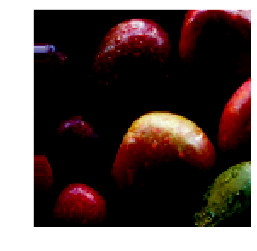

In [170]:
plt.imshow( (A_generator[0][0]))

## 吉村自作

In [171]:
import glob
apple_image_files = glob.glob( "./apple2orange/testA/img/*")

img = cv2.imread(apple_image_files [130]) # GBRになっちゃうよ！！(やめて

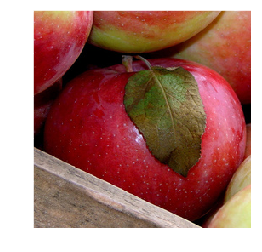

In [172]:
import cv2

# open cvで読み込み
# img = cv2.imread("./apple2orange/testA/img/n07740461_10011.jpg")

# 画像の色を変換
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

plt.imshow(img)


In [173]:
type(img)

numpy.ndarray

In [174]:
result = (G_AB.predict(img[np.newaxis, :, :, :])+1)/2

In [175]:
type(result[0])

numpy.ndarray

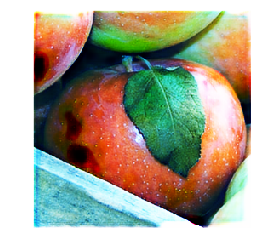

In [176]:
plt.imshow(result[0])

In [157]:
# plt.imshow(generated_imagesA[0] )


In [27]:
# result3 = G_AB.predict(img3[np.newaxis, :, :, :])



In [139]:
# mshow((result3[0]+1)*127.5)

##  立浪さんのコードだとうまくいく

In [37]:
generated_imagesA =(G_AB.predict(A_generator)+1)/2

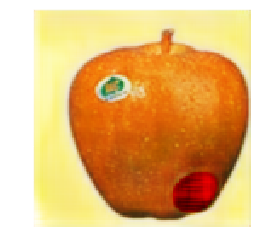

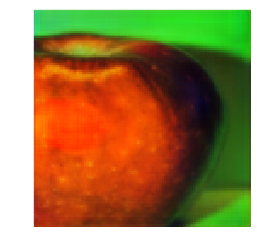

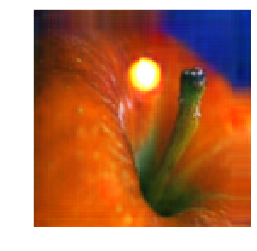

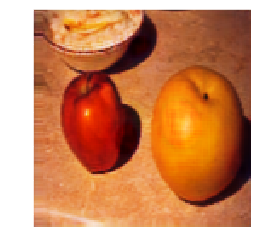

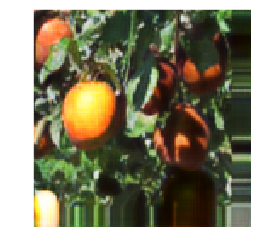

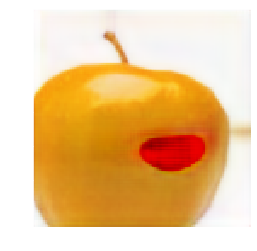

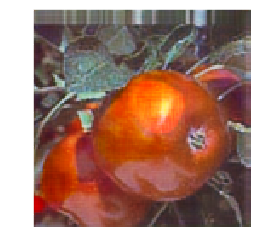

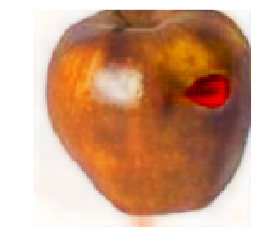

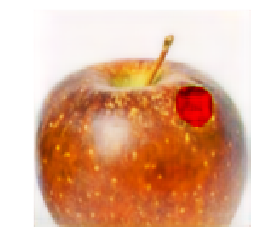

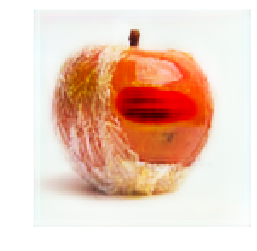

In [156]:
for i in range(10):
    plt.imshow(generated_imagesA[i])
    plt.show()